# Introduction to gradients and automatic differentiation

## Tensor

A **tensor** is the fundamental data structure in TensorFlow. In the context of TensorFlow, a tensor is essentially a **multi-dimensional array** or **list of numbers**.

It is the primary unit used to represent all data within a TensorFlow program, including inputs, outputs, model parameters, and intermediate results of calculations.

### Tensor Structure and Analogy

Tensors are simply generalizations of concepts you might already be familiar with:

| Mathematical Name | Rank (Dimensions) | TensorFlow Analogy | Example |
| :--- | :--- | :--- | :--- |
| **Scalar** | 0-D | A single number | `7` |
| **Vector** | 1-D | A list of numbers | `[1, 2, 3]` |
| **Matrix** | 2-D | A table of numbers (rows and columns) | `[[1, 2], [3, 4]]` |
| **3-Tensor** | 3-D | A cube or stack of matrices | `[[[...], [...]]]` |
| **N-Tensor** | N-D | A data structure with N axes | Images (4-D), Video (5-D) |

### Key Properties of a Tensor

Every tensor in TensorFlow is defined by three main properties:

1.  **Rank (or Axis):** The number of dimensions the tensor has. A rank-3 tensor has three axes.
2.  **Shape:** The size of the tensor along each dimension. For example, a $2 \times 3$ matrix has a shape of `(2, 3)`.
3.  **Data Type (DType):** The type of data contained in the tensor's elements, such as `tf.float32`, `tf.int64`, or `tf.bool`.

### Role in TensorFlow

In TensorFlow, tensors serve as the **data carriers** that flow through the computational graph (the "flow" in TensorFlow). Every operation (such as addition, matrix multiplication, or ReLU activation) takes one or more tensors as input and produces one or more tensors as output.

* **Input Data:** Images, text data, and numeric features are loaded and represented as tensors.
* **Model Weights:** Trainable parameters (weights and biases) are stored as **`tf.Variable`** objects, which are special, mutable types of tensors.
* **Calculations:** All mathematical operations performed during training and inference are tensor operations.

<br>
<br>
<br>

Here are a few notes from [TensorFlow documentation](https://www.tensorflow.org/guide/autodiff):

Automatic differentiation is useful for implementing machine learning algorithms such as backpropagation for training neural networks.

In this guide, you will explore ways to compute gradients with TensorFlow, especially in eager execution.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Computing gradients

To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the *forward pass*. Then, during the *backward pass*, TensorFlow traverses this list of operations in reverse order to compute gradients.


## Gradient tapes

TensorFlow provides the `tf.GradientTape` API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variables`. TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

Here is a simple example:

In [3]:
x = tf.Variable(3.0)

with tf.GradientTape(persistent=False) as tape:
    # y = x**2
    y = tf.sin(x) + x**2

The `persistent=True` argument in `tf.GradientTape()` makes the tape "persistent," meaning it will not discard the recorded operations after the first call to `tape.gradient()`. This allows you to calculate gradients multiple times using the same tape.

By default, `tf.GradientTape()` is non-persistent (`persistent=False`). After you call `tape.gradient()` once, the computational resources used to store the intermediate forward-pass results are freed, and the tape is effectively destroyed. If you try to call `tape.gradient()` a second time on the same tape, you will get an error.

Once you've recorded some operations, use `GradientTape.gradient(target, sources)` to calculate the gradient of some target (often a loss) relative to some source (often the model's variables):

In [4]:
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

np.float32(5.0100074)

The above example uses scalars, but `tf.GradientTape` works as easily on any tensor:

In [22]:
w = tf.Variable(tf.random.normal((3,2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
    y = tf.matmul(x, w) + b
    loss = tf.reduce_mean(y**2)

To get the gradient of loss with respect to both variables, you can pass both as sources to the gradient method. The tape is flexible about how sources are passed and will accept any nested combination of lists or dictionaries and return the gradient structured the same way (see `tf.nest`).

In [23]:
# grads = tape.gradient(loss, [w, b])
grads = tape.gradient(loss, {'w': w, 'b': b})
grads

{'w': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 2.7180297,  4.258385 ],
        [ 5.4360595,  8.51677  ],
        [ 8.154089 , 12.775156 ]], dtype=float32)>,
 'b': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.7180297, 4.258385 ], dtype=float32)>}

In [26]:
grads['w'].numpy()

array([[ 2.7180297,  4.258385 ],
       [ 5.4360595,  8.51677  ],
       [ 8.154089 , 12.775156 ]], dtype=float32)

## Gradients with respect to a model

It's common to collect `tf.Variables` into a `tf.Module` or one of its subclasses (`layers.Layer, keras.Model`) for checkpointing and exporting.

In most cases, you will want to calculate gradients with respect to a model's trainable variables. Since all subclasses of `tf.Module` aggregate their variables in the `Module.trainable_variables` property, you can calculate these gradients in a few lines of code: 

In [34]:
layer = tf.keras.layers.Dense(units=2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
    # Forward pass
    y = layer(x)
    loss = tf.reduce_mean(y**2)

# Calculate gradients wrt every trainable variable
grads = tape.gradient(loss, layer.trainable_variables)

In [38]:
for var, grad in zip(layer.trainable_variables, grads):
    print(f'{var.name}, shape: {grad.shape}')
    print(var.numpy())
    print(grad.numpy())

kernel, shape: (3, 2)
[[ 0.2148267  -0.10884553]
 [-0.18049848  0.45471025]
 [ 0.55419815  0.7707133 ]]
[[1.5164242 3.112715 ]
 [3.0328484 6.22543  ]
 [4.5492725 9.338145 ]]
bias, shape: (2,)
[0. 0.]
[1.5164242 3.112715 ]


## Controlling what the tape watches

The default behavior is to record all operations after accessing a trainable `tf.Variable`. The reasons for this are:

* The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
* The tape holds references to intermediate outputs, so you don't want to record unnecessary operations.
* The most common use case involves calculating the gradient of a loss with respect to all a model's trainable variables.

For example, the following fails to calculate a gradient because the `tf.Tensor` is not "watched" by default, and the `tf.Variable` is not trainable:

In [49]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a variable: A variable + tensor returns a tensor
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
    y = (x0**2) + (x1**2) + (x2**2) + x3

grads = tape.gradient(y, [x0, x1, x2, x3])

for grad in grads:
    print(grad)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


You can list the variables being watched by the tape using the `GradientTape.watched_variables` method:

In [50]:
tape.watched_variables()

(<tf.Variable 'x0:0' shape=() dtype=float32, numpy=3.0>,)

In [53]:
[var.name for var in tape.watched_variables()]

['x0:0']

`tf.GradientTape` provides hooks that give the user control over what is or is not watched. To record gradients with respect to a `tf.Tensor`, you need to call `GradientTape.watch(x)`:

In [56]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2

grad = tape.gradient(y, x)
print(grad.numpy())

6.0


Conversely, to disable the default behavior of watching all `tf.Variables`, set `watch_accessed_variables=False` when creating the gradient tape. This calculation uses two variables, but only connects the gradient for one of the variables:

In [63]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1)
    y0 = tf.math.sin(x0)
    y1 = tf.nn.softplus(x1) # Softplus(x)=ln(1+ex)
    y = y0 + y1                                              
    ys = tf.reduce_sum(y)

grads = tape.gradient(y, {'x0': x0, 'x1': x1})
grads

{'x0': None,
 'x1': <tf.Tensor: shape=(), dtype=float32, numpy=0.9999545812606812>}

## Intermediate results
You can also request gradients of the output with respect to intermediate values computed inside the `tf.GradientTape` context.

In [64]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
    z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
grad = tape.gradient(z, y)
print(grad.numpy())

18.0


By default, the resources held by a GradientTape are released as soon as the `GradientTape.gradient` method is called. To compute multiple gradients over the same computation, create a gradient tape with `persistent=True`. This allows multiple calls to the gradient method as resources are released when the tape object is garbage collected. For example:

In [65]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [66]:
del tape   # Drop the reference to the tape

## Notes on performance

* There is a tiny overhead associated with doing operations inside a gradient tape context. For most eager execution this will not be a noticeable cost, but you should still use tape context around the areas only where it is required.
* Gradient tapes use memory to store intermediate results, including inputs and outputs, for use during the backwards pass.
* For efficiency, some ops (like `ReLU`) don't need to keep their intermediate results and they are pruned during the forward pass. However, if you use `persistent=True` on your tape, nothing is discarded and your peak memory usage will be higher.

## Gradients of non-scalar targets

A gradient is fundamentally an operation on a scalar.

In [67]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


Thus, if you ask for the gradient of multiple targets, the result for each source is:

* The gradient of the sum of the targets, or equivalently
* The sum of the gradients of each target.

In [70]:
print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


In [75]:
del tape

Similarly, if the target(s) are not scalar the gradient of the sum is calculated:

In [76]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


This makes it simple to take the gradient of the sum of a collection of losses, or the gradient of the sum of an element-wise loss calculation.

If you need a separate gradient for each item, refer to `Jacobians`.

In some cases you can skip the Jacobian. For an element-wise calculation, the gradient of the sum gives the derivative of each element with respect to its input-element, since each element is independent:

In [81]:
x = tf.linspace(-10.0, 10.0, 200)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)

grad = tape.gradient(y, x)
# print(grad)

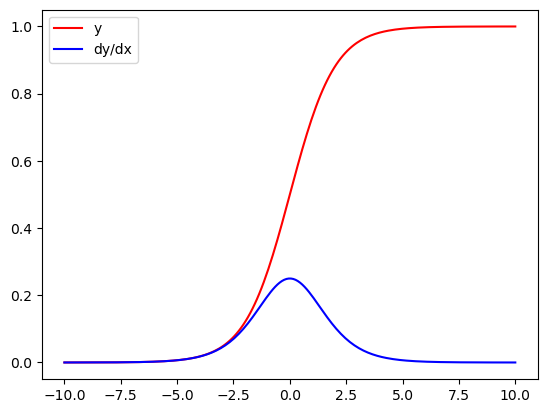

In [82]:
plt.plot(x, y, 'r-');
plt.plot(x, grad, 'b-');
plt.legend(['y', 'dy/dx'])

## Control flow

Because a gradient tape records operations as they are executed, Python control flow is naturally handled (for example, `if` and `while` statements).

Here a different variable is used on each branch of an `if`. The gradient only connects to the variable that was used:

In [101]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


Just remember that the control statements themselves are not differentiable, so they are invisible to gradient-based optimizers.

Depending on the value of `x` in the above example, the tape either records `result = v0` or `result = v1**2`. The gradient with respect to `x` is always `None`.

In [102]:
dx = tape.gradient(result, x)
print(dx)

None


## Cases where gradient returns None

When a target is not connected to a source, gradient will return `None`:
1. Replaced a variable with a tensor
2. Did calculations outside of TensorFlow
3. Took gradients through an integer or string
4. Took gradients through a stateful object

### 1. Replaced a variable with a tensor

In the section on "controlling what the tape watches" you saw that the tape will automatically watch a `tf.Variable` but not a `tf.Tensor`.

One common error is to inadvertently replace a `tf.Variable` with a `tf.Tensor`, instead of using `Variable.assign` to update the `tf.Variable`. Here is an example:

In [115]:
x = tf.Variable(2.0)

for epoch in range(2):
    with tf.GradientTape() as tape:
        y = x**2+1
    
    print(type(x).__name__, ":", tape.gradient(y, x))
    # x = x + 1   # This should be `x.assign_add(1)`
    x.assign_add(1.0)
    # x.assign(x*2.0)
    print(x.numpy())

ResourceVariable : tf.Tensor(4.0, shape=(), dtype=float32)
3.0
ResourceVariable : tf.Tensor(6.0, shape=(), dtype=float32)
4.0


### 2. Did calculations outside of TensorFlow

The tape can't record the gradient path if the calculation exits TensorFlow. For example:

In [130]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
    x2 = x**2
        
    # This step is calculated with NumPy
    y = np.mean(x2, axis=0)
    print(y)
    # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
    # using `tf.convert_to_tensor`.
    y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))
print(y)

[ 5. 10.]
None
tf.Tensor(7.5, shape=(), dtype=float32)


### 3. Took gradients through an integer or string

Integers and strings are not differentiable. If a calculation path uses these data types there will be no gradient. Nobody expects strings to be differentiable, but it's easy to accidentally create an int constant or variable if you don't specify the dtype.

TensorFlow doesn't automatically cast between types, so, in practice, you'll often get a type error instead of a missing gradient.

In [132]:
x = tf.constant(10)

with tf.GradientTape() as g:
    g.watch(x)
    y = x * x

print(g.gradient(y, x))

None


### 4. Took gradients through a stateful object

State stops gradients. When you read from a stateful object, the tape can only observe the current state, not the history that lead to it.

A `tf.Tensor` is immutable. You can't change a tensor once it's created. It has a value, but no state. All the operations discussed so far are also stateless: the output of a `tf.matmul` only depends on its inputs.

A `tf.Variable` has internal state — its value. When you use the variable, the state is read. It's normal to calculate a gradient with respect to a variable, but the variable's state blocks gradient calculations from going farther back. For example:

In [134]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
    # Update x1 = x1 + x0.
    x1.assign_add(x0)
    # The tape starts recording from x1.
    y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

None


Similarly, tf.data.Dataset iterators and tf.queues are stateful, and will stop all gradients on tensors that pass through them.

## Zeros instead of None

In some cases it would be convenient to get 0 instead of `None` for unconnected gradients. You can decide what to return when you have unconnected gradients using the `unconnected_gradients` argument:

In [135]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
    z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
